Why lower score than what's usually reported in literature? This is the small 100k rating dataset.
Explain how could NCF work? train set never sees y_test, unlike in NLP. But item embedding learns to detect patterns indirectly via user embedding.

In [ ]:
!pip install surprise -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, SVD, Reader
import time
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ratings_2018.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22
100832,610,168248,5.0,2017-05-03 22:21:31
100833,610,168250,5.0,2017-05-08 19:50:47
100834,610,168252,5.0,2017-05-03 21:19:12


In [ ]:
# drop movies with less than 3 ratings: movie in test must also exist in train
# actually find the smallest threshold so that all movies in test are also in train
valid_df = df.groupby('movieId').size()
def find_threshold(threshold, valid_movies=valid_df):
  valid_movies = valid_movies[valid_movies.apply(lambda x: x >= threshold)].index.values
  valid_df = pd.DataFrame(valid_movies,columns=['movieId']).merge(df, on='movieId')
  print(f"% of valid movies: {valid_movies.shape[0]/df['movieId'].nunique()}")
  print(f"% of valid records: {len(valid_df)/len(df)}")
  test_data = valid_df.groupby('userId').apply(lambda x: x.sort_values(by='timestamp',ascending=False).iloc[0]).reset_index(drop=True)
  merged = valid_df.merge(test_data,how='left',indicator=True)
  train_data = merged[merged['_merge'] == 'left_only'].drop('_merge',axis=1)
  return np.all([id in train_data['movieId'].unique() for id in test_data['movieId'].unique()]), train_data, test_data, valid_df


In [ ]:
# choose thres = 3
for thres in range(1,10):
  state, train_data, test_data, valid_df = find_threshold(thres)
  print(thres, state)
  if state:
    break

% of valid movies: 1.0
% of valid records: 1.0
1 False
% of valid movies: 0.6456190867955574
% of valid records: 0.965825697171645
2 False
% of valid movies: 0.5121349238996298
% of valid records: 0.9400809234797096
3 True


In [ ]:
train_data

,movieId,userId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,5,4.0,1996-11-08 06:36:02
2,1,7,4.5,2005-01-25 06:52:26
3,1,15,2.5,2017-11-13 12:59:30
4,1,17,4.5,2011-05-18 05:28:03
...,...,...,...,...
94789,187595,514,3.0,2018-09-23 03:55:46
94790,187595,586,5.0,2018-06-25 04:05:56
94791,188301,50,3.0,2018-08-03 13:17:57
94792,188301,380,4.0,2018-08-13 01:23:02


In [ ]:
test_data

,movieId,userId,rating,timestamp
0,2492,1,4.0,2000-08-08 07:27:42
1,80489,2,4.5,2015-10-24 19:35:40
2,2424,3,0.5,2011-05-27 02:44:53
3,4246,4,4.0,2001-12-05 17:49:02
4,474,5,4.0,1996-11-08 06:42:17
...,...,...,...,...
605,2355,606,3.0,2013-05-13 15:56:17
606,4015,607,1.0,2001-08-15 03:49:47
607,52245,608,3.0,2007-09-12 02:25:17
608,1161,609,4.0,1996-11-05 19:11:20


In [ ]:
test_data.to_csv('/content/drive/MyDrive/recommender_test.csv')

In [ ]:
train_data.to_csv('/content/drive/MyDrive/recommender_train.csv')

In [ ]:
valid_df.to_csv('/content/drive/MyDrive/recommender_valid.csv')

In [ ]:
# baseline itempop
watch_hist = train_data.groupby('userId').apply(lambda x: x['movieId'].unique()).rename('watch_history')
watch_hist

,watch_history
userId,
1,"[1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,..."
2,"[318, 333, 1704, 3578, 6874, 8798, 46970, 4851..."
3,"[31, 527, 647, 688, 720, 849, 914, 1093, 1124,..."
4,"[21, 32, 45, 47, 52, 58, 125, 126, 162, 171, 1..."
5,"[1, 21, 34, 36, 39, 50, 58, 110, 150, 153, 232..."
...,...
606,"[1, 7, 11, 15, 17, 18, 19, 28, 29, 32, 36, 46,..."
607,"[1, 11, 25, 34, 36, 86, 110, 112, 150, 153, 16..."
608,"[1, 2, 3, 10, 16, 19, 21, 24, 31, 32, 34, 39, ..."


In [ ]:
all_movies = valid_df['movieId'].unique()
# unwatch hist does not include the last interaction from each user, will append together later
unwatch_hist = valid_df.groupby('userId').apply(lambda x: x['movieId'].unique()).apply(lambda x: np.setdiff1d(all_movies, x)).rename('unwatch_history')
unwatch_hist

,unwatch_history
userId,
1,"[2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
5,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
...,...
606,"[2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 20, ..."
607,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 1..."
608,"[4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18,..."


**<h3>Popularity - Baseline**

In [ ]:
def itempop(userid=None, k=10, implicit=True, df=valid_df):
  def personalized(userid=userid):
    user_ = pd.DataFrame(watch_hist[userid],columns=['movieId'])
    pop = df.merge(user_,indicator=True,how='outer')
    popular = pop[pop['_merge']=='left_only'].drop('_merge',axis=1).groupby('movieId')
    if implicit: # refactored
      popular = popular.size().sort_values(ascending=False)[:k]
    else:
      popular = popular['rating'].mean().sort_values(ascending=False)[:k]
    return popular.index.values
  def general():
    if implicit:
      popular = df.groupby('movieId').size().sort_values(ascending=False)[:k]
    else:
      popular = df.groupby('movieId')['rating'].mean().sort_values(ascending=False)[:k]
    return popular.index.values

  if userid:
    return personalized(userid)
  else:
    return general()

In [ ]:
predictions_implicit = test_data['userId'].apply(itempop).rename('rec_movies')
predictions_explicit = test_data['userId'].apply(lambda x: itempop(x,implicit=False)).rename('rec_movies')

In [ ]:
predictions_implicit

,rec_movies
0,"[318, 589, 150, 4993, 858, 5952, 7153, 588, 27..."
1,"[356, 296, 593, 2571, 260, 480, 110, 589, 527,..."
2,"[356, 318, 296, 593, 2571, 260, 480, 110, 589,..."
3,"[356, 318, 480, 110, 589, 527, 1, 50, 780, 150]"
4,"[356, 593, 2571, 260, 480, 2959, 1196, 2858, 4..."
...,...
605,"[150, 457, 588, 608, 380, 364, 377, 344, 58559..."
606,"[356, 2959, 50, 47, 1198, 4993, 5952, 7153, 58..."
607,"[1198, 58559, 165, 79132, 1197, 4973, 33794, 3..."
608,"[593, 2571, 260, 527, 2959, 1196, 2858, 50, 47..."


In [ ]:
def eval_HR(y_preds, y_true=test_data, k=10):
  if len(y_preds) == k:
    return y_true['movieId'].apply(lambda x: 1 if x in y_preds else 0).mean()
  else:
    return pd.merge(y_true, y_preds, left_index=True, right_index=True).apply(lambda x: 1 if x['movieId'] in x['rec_movies'] else 0, axis=1).mean()

In [ ]:
def eval_NDCG(y_preds: pd.Series, y_true=test_data, k=10):
  def ndcg_score(idx_arr: np.ndarray, k=10):
    if len(idx_arr) == 0:
      return 0
    if not isinstance(idx_arr,np.ndarray):
      idx_arr = np.array(idx_arr)
    ideal_indices = np.arange(len(idx_arr))
    nom = 1/np.log2(idx_arr + 1 + 1).sum()
    denom = 1/np.log2(ideal_indices + 1 + 1).sum()
    return nom/denom
  if len(y_preds) == k:
    return  y_true['movieId'].apply(lambda x: np.where(y_preds == x)[0]).apply(ndcg_score).mean()
  else:
    assert y_preds.name == 'rec_movies', 'Wrong naming convention!'
    return pd.merge(test_data, y_preds, left_index=True, right_index=True).apply(
      lambda x: np.where(x['rec_movies']==x['movieId'])[0], axis=1).apply(ndcg_score).mean()

In [ ]:
# test eval_NDCG
def ndcg_score(idx_arr: np.ndarray, k=10):
  if len(idx_arr) == 0:
    return 0
  if not isinstance(idx_arr,np.ndarray):
    idx_arr = np.array(idx_arr)
  ideal_indices = np.arange(len(idx_arr))
  nom = 1/np.log2(idx_arr + 1 + 1).sum()
  denom = 1/np.log2(ideal_indices + 1 + 1).sum()
  return nom/denom

ndcg_score([0,1,2,3,4,5])

1.0

In [ ]:
# log discounting
zeros = np.zeros(10)
scores = {}
for hit in [1,2]:
  scores[hit] = []
  for j in range(zeros.shape[0]):
    zeros[j:j+hit] = 1
    score = 0
    for i, val in enumerate(zeros):
      score += (2**val - 1)/np.log2(i+1+1)
    scores[hit].append(score)
    zeros[j] = 0

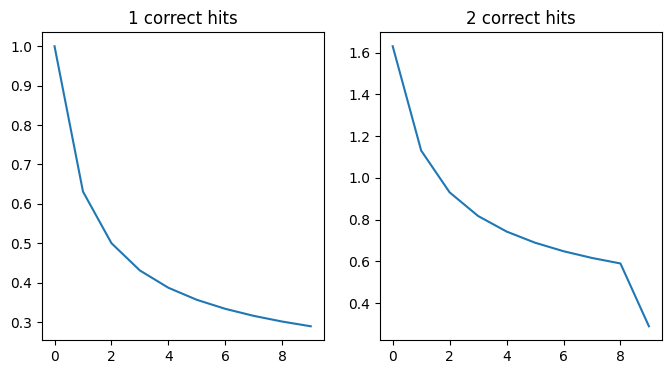

In [ ]:
# exception: miscalculated last position in right plot
fig, ax = plt.subplots(1,2,figsize=(8,4))
for i, num in enumerate(scores.keys()):
  ax[i].plot(scores[i+1])
  ax[i].set_title(f'{num} correct hits');

In [ ]:
eval_NDCG(predictions_implicit)

0.019845449308594113

In [ ]:
eval_HR(predictions_implicit)

0.04262295081967213

In [ ]:
general_implicit = itempop()

In [ ]:
eval_HR(general_implicit)

0.02459016393442623

In [ ]:
eval_NDCG(general_implicit)

0.010565495204285756

**<h3>User-based and Item-based Collaborative Filtering</h3>**

In [ ]:
# user-based collaborative filtering
rating_df = train_data.pivot_table(index='userId',columns='movieId',values='rating').copy().fillna(0)
rating_df

movieId,1,2,3,4,5,6,7,8,9,10,...,180985,182715,182823,183897,184471,185029,187541,187593,187595,188301
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# item-based collaborative filtering
item_df = rating_df.transpose()
item_df

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# statistics of total interactions for each movie in train_data
item_df.apply(lambda x: (x > 0.0).sum(), axis=1).describe()

,0
count,4980.000000
mean,18.912450
std,28.568399
min,1.000000
25%,4.000000
50%,8.000000
75%,20.000000
max,328.000000


In [ ]:
item_similarities = cosine_similarity(item_df, item_df)
item_sim = pd.DataFrame(item_similarities, index=item_df.index, columns=item_df.index)
item_sim

movieId,1,2,3,4,5,6,7,8,9,10,...,180985,182715,182823,183897,184471,185029,187541,187593,187595,188301
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.411316,0.301989,0.035702,0.303472,0.373541,0.278500,0.132108,0.219693,0.388754,...,0.042247,0.048298,0.089733,0.047197,0.086575,0.063955,0.047428,0.108093,0.088797,0.120007
2,0.411316,1.000000,0.290570,0.108031,0.280051,0.304127,0.232048,0.175118,0.046767,0.405537,...,0.000000,0.154577,0.128130,0.000000,0.148436,0.000000,0.000000,0.185017,0.205423,0.085351
3,0.301989,0.290570,1.000000,0.093644,0.427248,0.290554,0.408227,0.317633,0.288339,0.246208,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064978,0.000000
4,0.035702,0.108031,0.093644,1.000000,0.190089,0.090460,0.275035,0.158022,0.000000,0.095598,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.303472,0.280051,0.427248,0.190089,1.000000,0.287543,0.478311,0.286101,0.315494,0.220043,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035649,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185029,0.063955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.448363,0.000000,0.000000,0.000000,0.508628,1.000000,0.000000,0.262593,0.317547,0.000000
187541,0.047428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.028120,0.000000,0.000000,1.000000,0.259645,0.000000,0.000000
187593,0.108093,0.185017,0.000000,0.000000,0.000000,0.100304,0.000000,0.000000,0.000000,0.059580,...,0.134294,0.509933,0.343333,0.099783,0.486050,0.262593,0.259645,1.000000,0.529907,0.150167


In [ ]:
similarities = cosine_similarity(rating_df, rating_df)
user_sim = pd.DataFrame(similarities, index=rating_df.index, columns=rating_df.index)
user_sim

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.028850,0.077834,0.199384,0.131459,0.128039,0.160126,0.138665,0.068220,0.017668,...,0.075808,0.165522,0.239653,0.073586,0.161702,0.183717,0.273170,0.294242,0.097128,0.161378
2,0.028850,1.000000,0.000000,0.003999,0.017705,0.027224,0.029115,0.028874,0.000000,0.073888,...,0.217430,0.017762,0.013583,0.000000,0.000000,0.033284,0.013738,0.048875,0.029939,0.111958
3,0.077834,0.000000,1.000000,0.002978,0.006593,0.005214,0.000000,0.006451,0.000000,0.000000,...,0.006675,0.006350,0.034256,0.000000,0.014516,0.017731,0.025169,0.027542,0.000000,0.045998
4,0.199384,0.003999,0.002978,1.000000,0.132982,0.092236,0.114435,0.064699,0.012240,0.026630,...,0.086082,0.127450,0.336110,0.055994,0.090357,0.221259,0.135585,0.151420,0.033919,0.119289
5,0.131459,0.017705,0.006593,0.132982,1.000000,0.300449,0.110130,0.437754,0.000000,0.032298,...,0.070309,0.404926,0.120105,0.271541,0.157791,0.120014,0.156211,0.138060,0.273258,0.068031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.183717,0.033284,0.017731,0.221259,0.120014,0.112611,0.223399,0.111403,0.089204,0.101092,...,0.196956,0.129860,0.352473,0.076127,0.172640,1.000000,0.171844,0.292707,0.080012,0.246499
607,0.273170,0.013738,0.025169,0.135585,0.156211,0.161074,0.188369,0.188070,0.012616,0.010979,...,0.095187,0.201889,0.220981,0.144010,0.125449,0.171844,1.000000,0.286611,0.155384,0.155009
608,0.294242,0.048875,0.027542,0.151420,0.138060,0.181145,0.326417,0.185831,0.106638,0.081077,...,0.158071,0.197292,0.251911,0.158684,0.187543,0.292707,0.286611,1.000000,0.126653,0.355793


In [ ]:
# check that no row has only zeros
user_sim.apply(lambda x: x.sum() == 0).sum()

0

In [ ]:
# sanity check a few vector pairs having max similarity:
def check(i1, i2):
  check_ = item_df.loc[[i1, i2]]
  return check_.transpose()[check_.apply(lambda x: x.loc[i1] != x.loc[i2])]

In [ ]:
movie_hist = valid_df.groupby('movieId')['userId'].unique()
def compute_weighted_mean(movieid, userid, item_based):
  # print(f"movieid {movieid}, userid {userid}")
  # return weighted mean
  if item_based:
    user_specific = pd.concat([item_sim[movieid][watch_hist[userid]].rename('sim'),item_df[userid][item_df[userid].apply(lambda x: x > 0.0)].rename('rating')],axis=1)
    weighted_mean = (user_specific['sim']*user_specific['rating']).sum()/user_specific['sim'].apply(abs).sum()
  else:
    item_specific = pd.concat([user_sim[userid][movie_hist[movieid]].rename('sim'),rating_df[movieid][rating_df[movieid].apply(lambda x: x > 0.0)].rename('rating')],axis=1)
    weighted_mean = (item_specific['sim']*item_specific['rating']).sum()/item_specific['sim'].apply(abs).sum()
  return weighted_mean

In [ ]:
# negative sampling: sample 100 items that user i hasn't interacted with, rank with target item = 101 in total
def negative_sampling(size=100):
  np.random.seed(211198)
  sampled_df = pd.merge(unwatch_hist.apply(lambda x:np.random.choice(x,size=size,replace=False)).reset_index(),
                        test_data, on='userId')
  final_df = sampled_df.apply(lambda x: np.append(x['movieId'],x['unwatch_history']), axis=1).rename('sample')
  final_df.index = sampled_df['userId']
  return final_df

In [ ]:
# will rank among these samples for each user
# check if unique samples
sample1 = negative_sampling()
sample1
sample1.apply(lambda x: len(list(set(x))) == len(x)).all()

True

In [ ]:
(sample1.apply(len) == 101).all()

True

In [ ]:
sample1 = sample1.reset_index()

In [ ]:
sample1

,userId,sample
0,1,"[2492, 44972, 1255, 5881, 2471, 3420, 4246, 39..."
1,2,"[80489, 8783, 3408, 3706, 55444, 2676, 74154, ..."
2,3,"[2424, 56715, 70641, 3712, 112515, 248, 6695, ..."
3,4,"[4246, 2300, 7846, 8838, 91126, 49220, 761, 11..."
4,5,"[474, 2017, 44694, 2383, 82852, 122900, 5989, ..."
...,...,...
605,606,"[2355, 4545, 7650, 1372, 2105, 416, 520, 85, 8..."
606,607,"[4015, 25841, 1459, 73321, 556, 3618, 69134, 6..."
607,608,"[52245, 83613, 75, 53519, 52328, 81932, 1247, ..."
608,609,"[1161, 4317, 3565, 4304, 2735, 8341, 107348, 7..."


In [ ]:
sample1.to_csv('/content/drive/MyDrive/sample1.csv')

In [ ]:
# compute predictions and rank for item_based
start_time = time.time()
sample1['predicted_rating'] = sample1.apply(lambda x: [compute_weighted_mean(userid=x['userId'],movieid=id,item_based=True) for
                                       id in x['sample']], axis=1)
end_time = time.time()
print(f"Prediction time: {end_time - start_time}")

Prediction time: 239.367356300354


In [ ]:
item_based_predictions = sample1['predicted_rating'].apply(lambda x: np.argsort(x)[::-1][:10]).rename('rec_movies')
item_based_predictions

,rec_movies
0,"[67, 55, 60, 85, 48, 61, 54, 77, 33, 94]"
1,"[53, 6, 44, 3, 41, 36, 39, 29, 61, 37]"
2,"[4, 31, 52, 35, 75, 19, 68, 97, 10, 13]"
3,"[93, 75, 20, 50, 95, 84, 37, 67, 78, 96]"
4,"[33, 64, 4, 67, 1, 43, 73, 93, 98, 62]"
...,...
605,"[16, 52, 44, 99, 17, 8, 66, 95, 32, 89]"
606,"[91, 42, 75, 99, 8, 32, 66, 25, 68, 33]"
607,"[11, 52, 32, 94, 67, 25, 8, 57, 46, 76]"
608,"[99, 77, 43, 62, 21, 63, 94, 6, 71, 60]"


In [ ]:
eval_HR(item_based_predictions)

0.001639344262295082

In [ ]:
eval_NDCG(item_based_predictions)

0.0010343110714286189

In [ ]:
# compute predictions and rank for user_based
start_time = time.time()
sample1['user_based_predicted_rating'] = sample1.apply(lambda x: [compute_weighted_mean(userid=x['userId'],movieid=id,item_based=False) for
                                       id in x['sample']], axis=1)
end_time = time.time()
print(f"Prediction time: {end_time - start_time}")

Prediction time: 131.7175235748291


In [ ]:
user_based_predictions = sample1['user_based_predicted_rating'].apply(lambda x: np.argsort(x)[::-1][:10]).rename('rec_movies')
user_based_predictions

,rec_movies
0,"[51, 84, 23, 9, 60, 35, 36, 94, 91, 71]"
1,"[9, 26, 43, 80, 39, 12, 32, 45, 40, 18]"
2,"[82, 4, 60, 72, 68, 98, 13, 99, 58, 46]"
3,"[95, 62, 75, 7, 64, 57, 67, 24, 29, 77]"
4,"[87, 35, 48, 91, 65, 21, 56, 77, 61, 63]"
...,...
605,"[16, 52, 83, 38, 8, 71, 91, 94, 44, 76]"
606,"[100, 42, 37, 75, 81, 71, 48, 1, 18, 41]"
607,"[32, 10, 31, 82, 6, 40, 65, 36, 8, 21]"
608,"[53, 90, 99, 11, 55, 42, 43, 38, 92, 75]"


In [ ]:
user_based_predictions.to_csv('/content/drive/MyDrive/user_based_predictions.csv')
item_based_predictions.to_csv('/content/drive/MyDrive/item_based_predictions.csv')

In [ ]:
eval_HR(user_based_predictions)

0.00819672131147541

In [ ]:
eval_NDCG(user_based_predictions)

0.0029494331609657416

**<h3>Matrix Factorization</h3>**

In [ ]:
reader = Reader(rating_scale=(1, 5))
svd_train = Dataset.load_from_df(train_data[['userId','movieId','rating']],reader=reader)

In [ ]:
trainset = svd_train.build_full_trainset()

In [ ]:
svd_test = sample1[['userId','sample']].explode('sample').values.tolist()

In [ ]:
svd = SVD()
svd.fit(trainset)

In [ ]:
svd_predictions = [svd.predict(*i) for i in svd_test]

In [ ]:
svd_dict = {'userId':[],
            'movieId': [],
            'predicted_rating': []}
for pred in svd_predictions:
  svd_dict['userId'].append(pred.uid)
  svd_dict['movieId'].append(pred.iid)
  svd_dict['predicted_rating'].append(pred.est)

In [ ]:
svd_predictions_df = pd.DataFrame(svd_dict)
svd_predictions_df

,userId,movieId,predicted_rating
0,1,2492,3.810116
1,1,44972,3.576685
2,1,1255,4.206274
3,1,5881,4.302418
4,1,2471,3.651648
...,...,...,...
61605,610,60293,4.237717
61606,610,2287,3.667359
61607,610,2495,3.747021
61608,610,542,2.954561


In [ ]:
svd_predictions_movies = svd_predictions_df.groupby('userId').apply(lambda x: x.sort_values(by='predicted_rating', ascending=False)[:10]['movieId'].values).rename('rec_movies')
svd_predictions_movies

,rec_movies
userId,
1,"[4973, 1235, 112175, 955, 3424, 54881, 5291, 7..."
2,"[1201, 720, 3675, 36535, 8368, 1218, 595, 3814..."
3,"[1225, 1104, 318, 1276, 3306, 2761, 80463, 377..."
4,"[1204, 1206, 6565, 76093, 1446, 943, 2300, 346..."
5,"[1704, 44191, 745, 1217, 5379, 127098, 3090, 5..."
...,...
606,"[1262, 1283, 1945, 5903, 96079, 290, 54190, 97..."
607,"[272, 29, 150548, 1245, 8981, 1066, 8645, 2584..."
608,"[54997, 1248, 39292, 1266, 3916, 61024, 27773,..."


In [ ]:
eval_HR(svd_predictions_movies)

0.006568144499178982

In [ ]:
eval_NDCG(svd_predictions_movies)

0.003177985754780453

In [ ]:
user_matrix = svd.pu[:,:2]
item_matrix = svd.qi[:,:2]

In [ ]:
item_matrix.shape

(4980, 2)

In [ ]:
# use this for embedding table later as well - bug in users
item_to_raw_id = {trainset.to_raw_iid(iid): iid for iid in trainset.all_items()}
user_to_raw_id = {trainset.to_raw_iid(iid): iid for iid in trainset.all_users()}

In [ ]:
# add title and plot
titles = pd.read_csv('/content/drive/MyDrive/movies.csv')
titles.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [ ]:
valid_titles = pd.merge(pd.DataFrame(list(item_to_raw_id.keys()),columns=['movieId']),titles,on='movieId')
valid_titles.tail()

,movieId,title,genres
4975,185029,A Quiet Place (2018),Drama|Horror|Thriller
4976,187541,Incredibles 2 (2018),Action|Adventure|Animation|Children
4977,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi
4978,187595,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi
4979,188301,Ant-Man and the Wasp (2018),Action|Adventure|Comedy|Fantasy|Sci-Fi


In [ ]:
latent_df = pd.concat([pd.DataFrame(item_matrix,columns=['x','y']),valid_titles],axis=1)
latent_df.head()

,x,y,movieId,title,genres
0,0.034318,0.078498,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,0.042653,-0.150351,2,Jumanji (1995),Adventure|Children|Fantasy
2,0.000296,-0.041631,3,Grumpier Old Men (1995),Comedy|Romance
3,0.030752,-0.018374,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,0.159147,-0.053280,5,Father of the Bride Part II (1995),Comedy


In [ ]:
def plot_latent(df=latent_df,num=None,blue_genre='Romance'):
  if not num:
    num = len(df)
  plt.scatter(df['x'].iloc[:num].values,df['y'].iloc[:num].values,
              color=np.array(['blue','darkred'])[(df['genres'].values == blue_genre).astype(int)],
              alpha=0.5)
  for i in range(num):
      plt.text(df['x'].values[i],df['y'].values[i], df['title'].values[i], fontsize=8, ha='center',va='bottom',alpha=0.6);

In [ ]:
# plot movies of only 2 genres: romance and scifi
genre_df = latent_df[latent_df['genres'].apply(lambda x: len(x.split('|')) == 1)]
filter_genre = genre_df[genre_df['genres'].apply(lambda x: x in ['Romance','Sci-Fi'])]

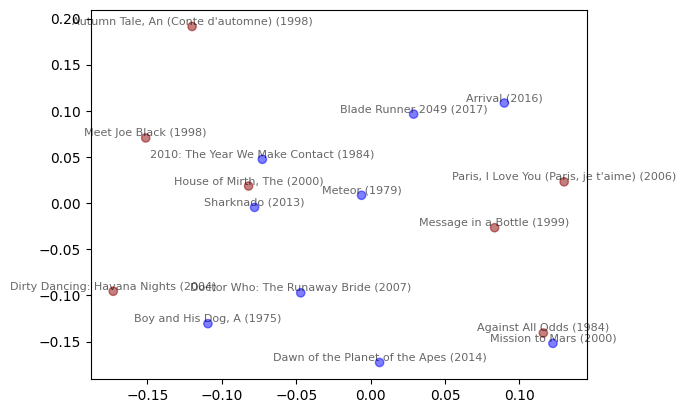

In [ ]:
plot_latent(df=filter_genre)

**<h3>Neural Colaborative Filtering</h3>**

In [ ]:
# a bit weird if train target are all 1's => check again in paper
X_train = train_data[['movieId','userId']]
y_train = (train_data['rating'] > 0).astype(int)

In [ ]:
movietoe = {id:i for i, id in enumerate(X_train['movieId'].sort_values().unique())}
usertoe = {id:i for i, id in enumerate(X_train['userId'].sort_values().unique())}

In [ ]:
X_train['movieId'] = X_train['movieId'].apply(lambda x: movietoe[x])
X_train['userId'] = X_train['userId'].apply(lambda x: usertoe[x])

In [ ]:
ncf_test = pd.merge(sample1[['userId','sample']].explode('sample').rename(columns={'sample':'movieId'}),
         test_data[['userId','movieId']],on=['userId','movieId'],how='outer',indicator=True)
ncf_test['rating'] = ncf_test['_merge'].apply(lambda x: 1 if x == 'both' else 0)

In [ ]:
# ncf_test.drop('_merge',axis=1,inplace=True)

In [ ]:
X_test = ncf_test[['movieId','userId']].astype(int)
y_test = ncf_test['rating']
X_test['movieId'] = X_test['movieId'].apply(lambda x: movietoe[x])
X_test['userId'] = X_test['userId'].apply(lambda x: usertoe[x])

In [ ]:
# can experiment with other hyperparams later
batch_size = 60
num_users = X_train['userId'].nunique()
num_items = X_train['movieId'].nunique()
embedding_dim = 16
print(num_users, num_items)

610 4980


In [ ]:
X_train = torch.tensor(X_train.values)
X_test = torch.tensor(X_test.values)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
import torch
import torch.nn as nn

# without dropout
class NCF(nn.Module):
  def __init__(self, num_users, num_items, embedding_dim, hidden_dims=[64, 32, 16, 8]):
    super().__init__()
    self.user_embedding = nn.Embedding(num_users, embedding_dim)
    self.item_embedding = nn.Embedding(num_items, embedding_dim)

    layers = []
    input_dim = 2 * embedding_dim
    for dim in hidden_dims:
      layers.append(nn.Linear(input_dim, dim))
      layers.append(nn.ReLU())
      input_dim = dim

    layers.append(nn.Linear(input_dim, 1))
    self.mlp = nn.Sequential(*layers)

  def forward(self, idx, y=None): # idx.shape = B, 2
    item, user = idx[:,0], idx[:,1]
    user_emb = self.user_embedding(user)
    item_emb = self.item_embedding(item)
    x = torch.cat([user_emb, item_emb], dim=1)
    x = self.mlp(x)
    return x.squeeze() # x.shape = batchsize, 1

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# set batch_size = median interaction counts per user, crucial for sequential recommender but try for NCF as well
train_data.groupby('userId').size().median()

68.5

In [ ]:
# positive rate in y_test
torch.where(y_test == 1,1,0).sum()/y_test.shape[0]

tensor(0.0099)

In [ ]:
# y has 1 dim
def get_batch(split,batch_size=batch_size):
  X = X_train if split == 'train' else X_test
  Y = y_train if split == 'train' else y_test
  ix = torch.randint(len(X), (batch_size,))
  x = torch.stack([X[i] for i in ix])
  y = torch.stack([Y[i] for i in ix])
  x,y = x.to(device), y.to(device)
  return x,y

In [ ]:
ncf = NCF(num_users=num_users, num_items=num_items, embedding_dim=embedding_dim).to(device)
ncf_loss = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(ncf.parameters())

In [ ]:
# try overfit 1 batch => succeed
temp_x, temp_y = get_batch('train')
for steps in range(100):
  logits = ncf.forward(temp_x)
  cost = ncf_loss(logits, temp_y)
  if steps % 10 == 0:
    print(cost.item())
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

0.012295542284846306
0.007307008374482393
0.0037738222163170576
0.0021942027378827333
0.0014619356952607632
0.0010755184339359403
0.0008447279105894268
0.0006920549785718322
0.0005831419839523733
0.0005012715701013803


In [ ]:
max_iters = 50
train_loss, test_loss = [], []
ncf = NCF(num_users=num_users, num_items=num_items, embedding_dim=embedding_dim).to(device)
ncf_loss = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.AdamW(ncf.parameters())
for step in range(max_iters):
  xb, yb = get_batch('train',batch_size=100)
  logits = ncf(xb)
  cost = ncf_loss(logits, yb)
  train_loss.append(cost.item())
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  ncf.eval()
  with torch.no_grad():
    xb, yb = get_batch('test',batch_size=100)
    logits = ncf(xb)
    cost = ncf_loss(logits, yb)
    test_loss.append(cost.item())

  if step % 10 == 0:
    print(f"step {step}: train loss {train_loss[step]:.4f}, test loss {test_loss[step]:.4f}")


step 0: train loss 0.8223, test loss 0.5878
step 10: train loss 0.7745, test loss 0.6222
step 20: train loss 0.7285, test loss 0.6652
step 30: train loss 0.6553, test loss 0.7455
step 40: train loss 0.5286, test loss 0.9059


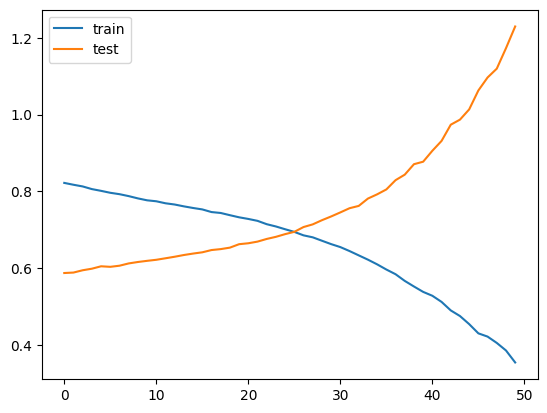

In [ ]:
pd.DataFrame({'train':train_loss,'test':test_loss}).plot();

In [ ]:
# can sigmoid but here did not do that
ncf_test['predicted_rating'] = ncf(X_test).detach().cpu().numpy()
ncf_test

,userId,movieId,rating,predicted_rating
0,1,28,0,1.016197
1,1,89,0,0.804538
2,1,533,0,0.753335
3,1,540,0,0.723881
4,1,550,0,0.931066
...,...,...,...,...
61605,610,83177,0,0.795565
61606,610,91104,0,0.735137
61607,610,98154,0,0.629247
61608,610,127096,0,0.686875


In [ ]:
ncf_predictions = ncf_test.groupby('userId').apply(lambda x: x.sort_values(by='predicted_rating',ascending=False)[:10].movieId.values).rename('rec_movies')
ncf_predictions

,rec_movies
userId,
1,"[110127, 112175, 71282, 54997, 3420, 25841, 70..."
2,"[4366, 431, 3386, 117590, 2275, 4508, 5570, 12..."
3,"[53125, 217, 6885, 6695, 2555, 79, 318, 4229, ..."
4,"[116, 168418, 1950, 49932, 2385, 68659, 1342, ..."
5,"[6695, 5421, 3917, 728, 168418, 1748, 587, 426..."
...,...
606,"[2921, 2555, 49932, 661, 135861, 4889, 56563, ..."
607,"[51662, 2475, 304, 3516, 110130, 4017, 1245, 1..."
608,"[3441, 2473, 52328, 26340, 5248, 40962, 7381, ..."


In [ ]:
eval_HR(ncf_predictions)

0.003284072249589491

In [ ]:
eval_NDCG(ncf_predictions)

0.0014059231315402662

**<h3>Tabulation</h3>**

In [ ]:
# 5 models in total thus far
metrics = {}
metrics['name'] = ['popularity_baseline','item_based','user_based','SVD_MF','NCF']
metrics['HR'] = [eval_HR(y_pred_df) for y_pred_df in [predictions_implicit, item_based_predictions,
                                                          user_based_predictions, svd_predictions_movies,ncf_predictions]]
metrics['NDCG'] = [eval_NDCG(y_pred_df) for y_pred_df in [predictions_implicit, item_based_predictions,
                                                          user_based_predictions, svd_predictions_movies, ncf_predictions]]
metrics_df = pd.DataFrame(metrics)
metrics_df

,name,HR,NDCG
0,popularity_baseline,0.042623,0.019845
1,item_based,0.001639,0.001034
2,user_based,0.008197,0.002949
3,SVD_MF,0.006568,0.003178
4,NCF,0.003284,0.001406


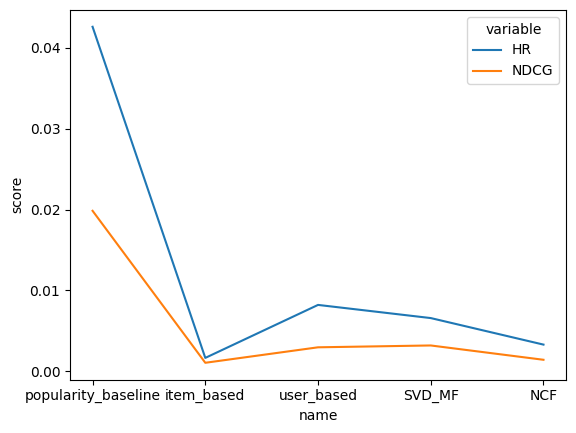

In [ ]:
import seaborn as sns
sns.lineplot(metrics_df.melt(id_vars='name',value_name='score'),x='name',y='score',hue='variable');